# **Projeto Series Temporais / Machine Learning- Previsão de Temperaturas**

Esse projeto trata da aplicação de Machine Learning em Series Temporais visando prever temperaturas horárias futuras. Duas abordagens foram utilizadas: Regressão e Forecasting.

Após a coleta dos dados, foi realizado tratamento e transformações para preparar o dataset para o treinamento e validação.

2 Bibliotecas foram utilizadas para o treinamento
- TSAI (Timeseries Ai) utilizando as arquiteturas abaixo
  - TST Plus (Time Series Transformer)
  - Inception Time Plus
  
- Prophet (biblioteca open-source da Facebook para series temporais)

MAE (Mean absolut error) foi a métrica utilizada para comparar os resultados dos modelos.


# Importar bibliotecas

https://timeseriesai.github.io/tsai/

In [ ]:

!pip install tsai prophet

!pip uninstall pystan cmdstanpy


!pip install pystan==2.19.1.1



  Using cached cmdstanpy-1.3.0-py3-none-any.whl.metadata (4.2 kB)
Using cached cmdstanpy-1.3.0-py3-none-any.whl (99 kB)


Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Would remove:
    /usr/local/bin/install_cmdstan
    /usr/local/bin/install_cxx_toolchain
    /usr/local/lib/python3.12/dist-packages/cmdstanpy-1.3.0.dist-info/*
    /usr/local/lib/python3.12/dist-packages/cmdstanpy/*
Proceed (Y/n)? ERROR: Operation cancelled by user
^C
^C


In [1]:
#Importação de Bibliotecas

from prophet import Prophet

from tsai.all import *


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score
from sklearn.model_selection import TimeSeriesSplit
from fastai.callback.all import EarlyStoppingCallback, SaveModelCallback
from tsai.metrics import mae

import seaborn as sns

#Importação dos Dados


**Fonte:** https://www.kaggle.com/datasets/parthdande/timeseries-weather-dataset

**Descrição dos dados**

time:	Tempo da observação.

temperature:	Temperatura medida em graus Celsius.

relative_humidity:	Umidade relativa expressa em porcentagem.

dew_point:	Temperatura do ponto de orvalho em graus Celsius.

precipitation (mm):	Quantidade de precipitação em milímetros.

rain (mm):	Quantidade de chuva em milímetros.

snowfall (cm):	Quantidade de neve em centímetros.

pressure_msl (hPa):	Pressão média ao nível do mar medida em hectopascais (hPa).

surface_pressure (hPa):	Pressão à superfície medida em hectopascais (hPa).

cloud_cover (%):	Cobertura de nuvens expressa em porcentagem.

cloud_cover_low (%):	Cobertura de nuvens baixas expressa em porcentagem.

cloud_cover_mid (%):	Cobertura de nuvens médias expressa em porcentagem.

cloud_cover_high (%):	Cobertura de nuvens altas expressa em porcentagem.

vapour_pressure_deficit (kPa):	Déficit de pressão de vapor medido em
kilopascais (kPa).

wind_speed_10m (km/h):	Velocidade do vento medida a 10 metros acima do nível
do solo em quilômetros por hora (km/h).

wind_direction:	Direção de onde o vento está soprando.

In [2]:
#Download dos dados

!curl -L -o /content/timeseries-weather-dataset.zip  https://www.kaggle.com/api/v1/datasets/download/parthdande/timeseries-weather-dataset

!unzip -q -o /content/timeseries-weather-dataset.zip -d /content/timeseries-weather-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.3M  100 11.3M    0     0  7128k      0  0:00:01  0:00:01 --:--:-- 10.1M


In [3]:
#Leitura dos dados em um df
df = pd.read_csv('/content/timeseries-weather-dataset/Weather_Data_1980_2024(hourly).csv')

In [4]:
#Visualização do dataframe
df.head()

time  temperature  relative_humidity  dew_point  \
0  1980-01-01T00:00         12.7                 83       10.0   
1  1980-01-01T01:00         12.9                 82        9.9   
2  1980-01-01T02:00         13.2                 82       10.2   
3  1980-01-01T03:00         15.9                 78       12.0   
4  1980-01-01T04:00         19.4                 67       13.1   

   precipitation (mm)  rain (mm)  snowfall (cm)  pressure_msl (hPa)  \
0                 0.0        0.0              0              1012.8   
1                 0.0        0.0              0              1012.2   
2                 0.0        0.0              0              1012.3   
3                 0.0        0.0              0              1013.5   
4                 0.0        0.0              0              1014.6   

   surface_pressure (hPa)  cloud_cover (%)  cloud_cover_low (%)  \
0                   945.1                1                    1   
1                   944.5                4                    4   
2                   944.7               13                   14   
3                   946.4               23                   26   
4                   948.2                9                   10   

   cloud_cover_mid (%)  cloud_cover_high (%)  vapour_pressure_deficit (kPa)  \
0                    0                     0                           0.25   
1                    0                     0                           0.26   
2                    0                     0                           0.27   
3                    0                     0                           0.40   
4                    0                     0                           0.75   

   wind_speed_10m (km/h)  wind_direction  is_Day  
0                    7.5             235       0  
1                    7.9             231       0  
2                    7.5             235       1  
3                    6.6             248       1  
4                    8.7             265       1

#EDA

In [5]:
#Informação geral dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389496 entries, 0 to 389495
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   time                           389496 non-null  object 
 1   temperature                    389496 non-null  float64
 2   relative_humidity              389496 non-null  int64  
 3   dew_point                      389496 non-null  float64
 4   precipitation (mm)             389496 non-null  float64
 5   rain (mm)                      389496 non-null  float64
 6   snowfall (cm)                  389496 non-null  int64  
 7   pressure_msl (hPa)             389496 non-null  float64
 8   surface_pressure (hPa)         389496 non-null  float64
 9   cloud_cover (%)                389496 non-null  int64  
 10  cloud_cover_low (%)            389496 non-null  int64  
 11  cloud_cover_mid (%)            389496 non-null  int64  
 12  cloud_cover_high (%)          

Não existem valores nulos nas colunas

In [6]:
#Transformar variável time de 'string' para 'datetime'
df['time']=df['time'].astype('datetime64[ns]')

In [7]:
#Filtrar os dados de 2018 em diante
df=df[df['time'].dt.year >=2018]

In [8]:
df

time  temperature  relative_humidity  dew_point  \
333120 2018-01-01 00:00:00         13.9                 81       10.7   
333121 2018-01-01 01:00:00         14.6                 75       10.2   
333122 2018-01-01 02:00:00         15.6                 69       10.0   
333123 2018-01-01 03:00:00         16.8                 69       11.0   
333124 2018-01-01 04:00:00         20.3                 56       11.2   
...                    ...          ...                ...        ...   
389491 2024-06-06 19:00:00         24.8                 90       23.0   
389492 2024-06-06 20:00:00         24.3                 92       22.9   
389493 2024-06-06 21:00:00         24.1                 91       22.5   
389494 2024-06-06 22:00:00         24.0                 89       22.1   
389495 2024-06-06 23:00:00         24.1                 88       22.0   

        precipitation (mm)  rain (mm)  snowfall (cm)  pressure_msl (hPa)  \
333120                 0.0        0.0              0              1011.0   
333121                 0.0        0.0              0              1011.3   
333122                 0.0        0.0              0              1012.0   
333123                 0.0        0.0              0              1013.2   
333124                 0.0        0.0              0              1013.8   
...                    ...        ...            ...                 ...   
389491                 0.0        0.0              0              1010.1   
389492                 0.0        0.0              0              1009.4   
389493                 0.0        0.0              0              1008.7   
389494                 0.0        0.0              0              1008.2   
389495                 0.0        0.0              0              1008.2   

        surface_pressure (hPa)  cloud_cover (%)  cloud_cover_low (%)  \
333120                   943.7                0                    0   
333121                   944.1                0                    0   
333122                   945.0                0                    0   
333123                   946.4                0                    0   
333124                   947.7                0                    0   
...                        ...              ...                  ...   
389491                   945.2               39                    2   
389492                   944.4               33                    3   
389493                   943.7               34                    4   
389494                   943.2               37                    8   
389495                   943.3               58                   31   

        cloud_cover_mid (%)  cloud_cover_high (%)  \
333120                    0                     0   
333121                    0                     0   
333122                    0                     0   
333123                    0                     0   
333124                    0                     0   
...                     ...                   ...   
389491                   12                   100   
389492                    1                   100   
389493                    1                   100   
389494                    0                   100   
389495                    0                   100   

        vapour_pressure_deficit (kPa)  wind_speed_10m (km/h)  wind_direction  \
333120                           0.30                    3.2             297   
333121                           0.42                    3.6             270   
333122                           0.55                    1.5             315   
333123                           0.60                    1.1             288   
333124                           1.06                    1.1             198   
...                               ...                    ...             ...   
389491                           0.32                   10.6             252   
389492                           0.25                   11.9             265   
389493    

In [9]:
#Checar duplicatas
df.duplicated().sum()

np.int64(0)

In [10]:
#Estatística descritiva das variáveis numéricas
df.describe(exclude='object')

time   temperature  relative_humidity     dew_point  \
count                56376  56376.000000       56376.000000  56376.000000   
mean   2021-03-20 11:30:00     24.450582          63.171137     15.346727   
min    2018-01-01 00:00:00      7.100000           7.000000     -4.600000   
25%    2019-08-11 05:45:00     21.600000          42.000000     10.500000   
50%    2021-03-20 11:30:00     23.800000          66.000000     15.900000   
75%    2022-10-28 17:15:00     27.400000          87.000000     21.200000   
max    2024-06-06 23:00:00     41.700000         100.000000     25.400000   
std                    NaN      5.316422          25.283731      5.949660   

       precipitation (mm)     rain (mm)  snowfall (cm)  pressure_msl (hPa)  \
count        56376.000000  56376.000000        56376.0        56376.000000   
mean             0.116872      0.116872            0.0         1010.357280   
min              0.000000      0.000000            0.0          992.100000   
25%              0.000000      0.000000            0.0         1007.200000   
50%              0.000000      0.000000            0.0         1010.500000   
75%              0.000000      0.000000            0.0         1013.700000   
max             27.300000     27.300000            0.0         1022.500000   
std              0.647563      0.647563            0.0            4.301544   

       surface_pressure (hPa)  cloud_cover (%)  cloud_cover_low (%)  \
count            56376.000000     56376.000000         56376.000000   
mean               945.331639        32.112317            17.190276   
min                928.300000         0.000000             0.000000   
25%                942.700000         0.000000             0.000000   
50%                945.700000        16.000000             0.000000   
75%                948.100000        58.000000            22.000000   
max                956.400000       100.000000           100.000000   
std                  3.748998        36.441787            29.863013   

       cloud_cover_mid (%)  cloud_cover_high (%)  \
count         56376.000000          56376.000000   
mean             18.436427             32.265077   
min               0.000000              0.000000   
25%               0.000000              0.000000   
50%               3.000000              0.000000   
75%              25.000000             83.000000   
max             100.000000            100.000000   
std              28.969771             41.760103   

       vapour_pressure_deficit (kPa)  wind_speed_10m (km/h)  wind_direction  \
count                   56376.000000           56376.000000    56376.000000   
mean                        1.353803              10.898155      208.545250   
min                         0.000000               0.000000        1.000000   
25%                         0.330000               6.600000       99.000000   
50%                         0.910000               9.600000      246.000000   
75%                         1.960000              14.500000      280.000000   
max                         7.250000              43.300000      360.000000   
std                         1.317141               5.882490       98.895587   

             is_Day  
count  56376.000000  
mean       0.507255  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000  
std        0.499952

In [11]:
# Eliminação de colunas. Precipitation e rain são similares. Snowfall só possui valores 0
df.drop(columns=['precipitation (mm)','snowfall (cm)'], inplace=True)

In [12]:
#Lista com as variáveis numéricas
num_columns = df.select_dtypes(include=['number']).columns
num_columns

Index(['temperature', 'relative_humidity', 'dew_point', 'rain (mm)',
       'pressure_msl (hPa)', 'surface_pressure (hPa)', 'cloud_cover (%)',
       'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)',
       'vapour_pressure_deficit (kPa)', 'wind_speed_10m (km/h)',
       'wind_direction', 'is_Day'],
      dtype='object')

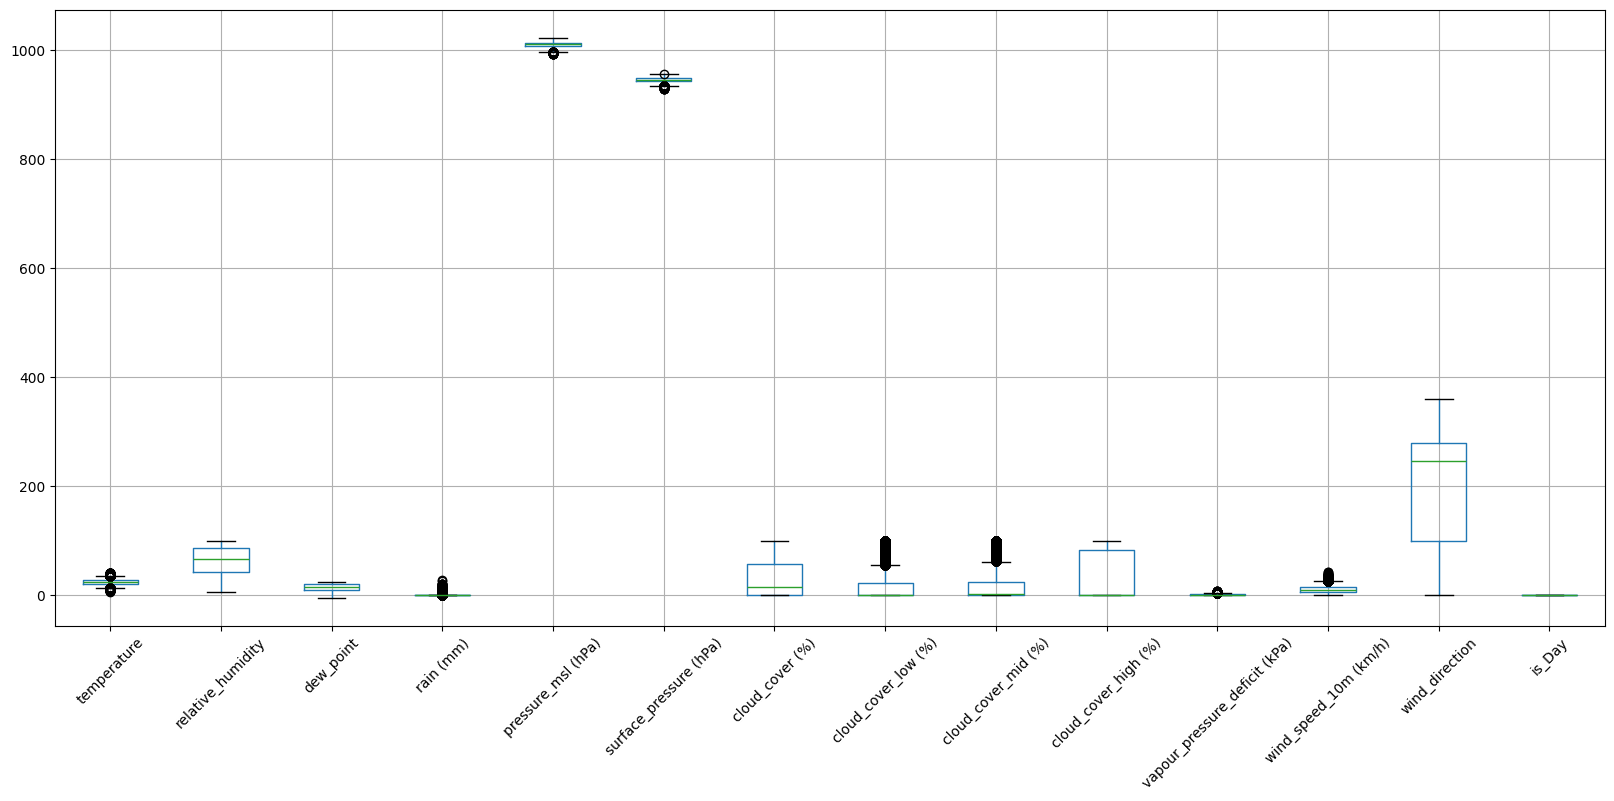

In [13]:
#Boxplot dos dados

plt.figure(figsize=(20,8))
df.boxplot()
plt.xticks(rotation=45)
plt.show()

<Axes: >

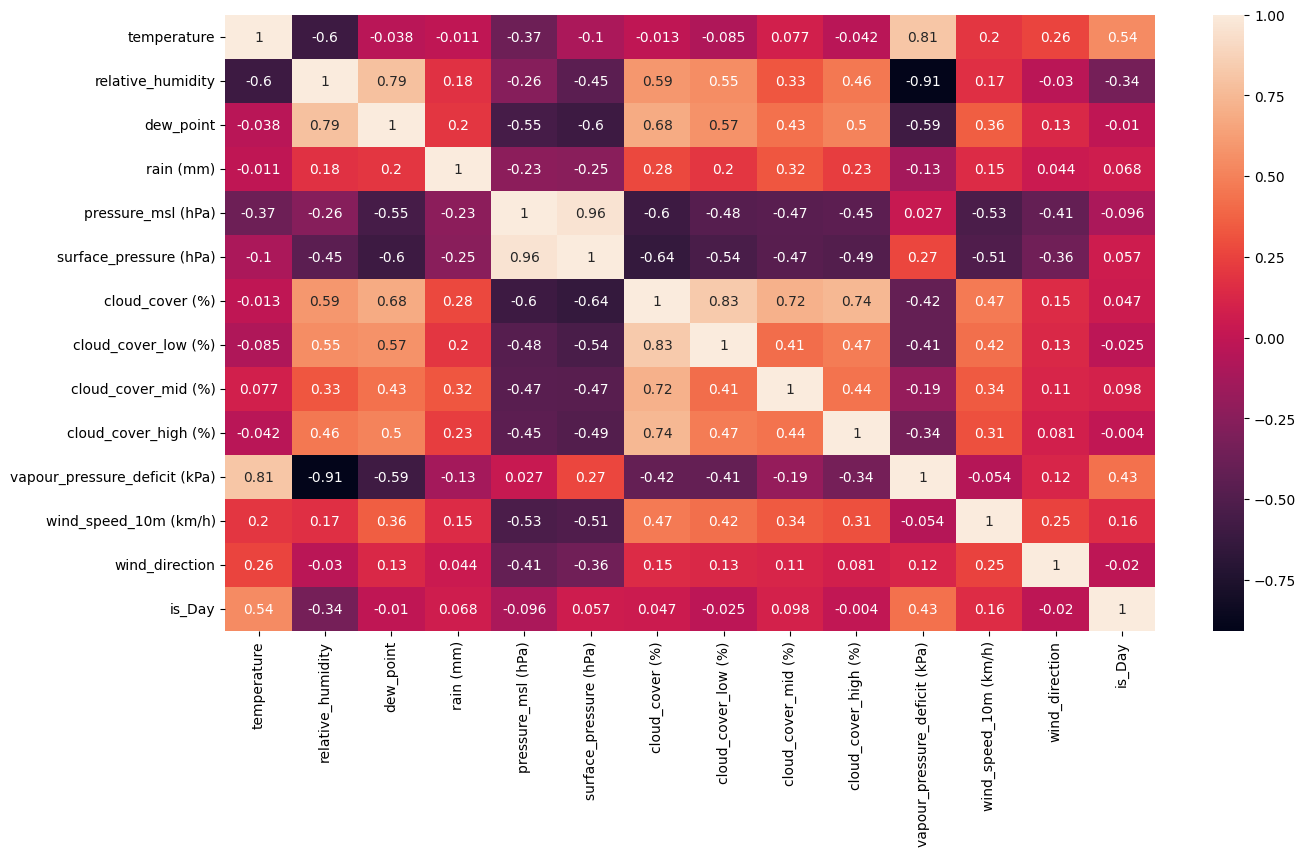

In [14]:
#Heatmap dos dados

plt.figure(figsize=(15,8))
sns.heatmap(df[num_columns].corr(), annot=True)

In [15]:
#Eliminar coluna sem uso
df=df.drop(columns=['is_Day'])

In [16]:
#Informações gerais do dataset após as transformações realizadas
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56376 entries, 333120 to 389495
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   time                           56376 non-null  datetime64[ns]
 1   temperature                    56376 non-null  float64       
 2   relative_humidity              56376 non-null  int64         
 3   dew_point                      56376 non-null  float64       
 4   rain (mm)                      56376 non-null  float64       
 5   pressure_msl (hPa)             56376 non-null  float64       
 6   surface_pressure (hPa)         56376 non-null  float64       
 7   cloud_cover (%)                56376 non-null  int64         
 8   cloud_cover_low (%)            56376 non-null  int64         
 9   cloud_cover_mid (%)            56376 non-null  int64         
 10  cloud_cover_high (%)           56376 non-null  int64         
 11  vapour_pressur

#Treinamentos e Validação

##Separação dos Dados em Treino e Teste

In [17]:
y = df['temperature'] #Variável de Saída
X=df.drop(columns=['temperature','time']) #Variáveis de entrada

In [18]:
#Transformar em Numpy
X=X.to_numpy()
y=y.to_numpy()

In [19]:
#Transformar dados de entrada em grupos de dados de entrada para uma saída
# 168 valores (7 dias) serão um grupo de entrada para 1 variável de saída

def create_sliding_window(X, y, window_size=168, horizon=1):
    """
    X: (n_samples, n_features)
    y: (n_samples,)
    window_size: quantos passos do passado usar
    horizon: quantos passos à frente prever (default = 1 passo futuro)
    """
    Xs, ys = [], []
    for i in range(len(X) - window_size - horizon + 1):
        Xs.append(X[i:i+window_size])         # sequência do passado
        ys.append(y[i+window_size+horizon-1]) # alvo futuro
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sliding_window(X, y, window_size=168, horizon=1)

print(X_seq.shape, y_seq.shape)

(56208, 168, 12) (56208,)


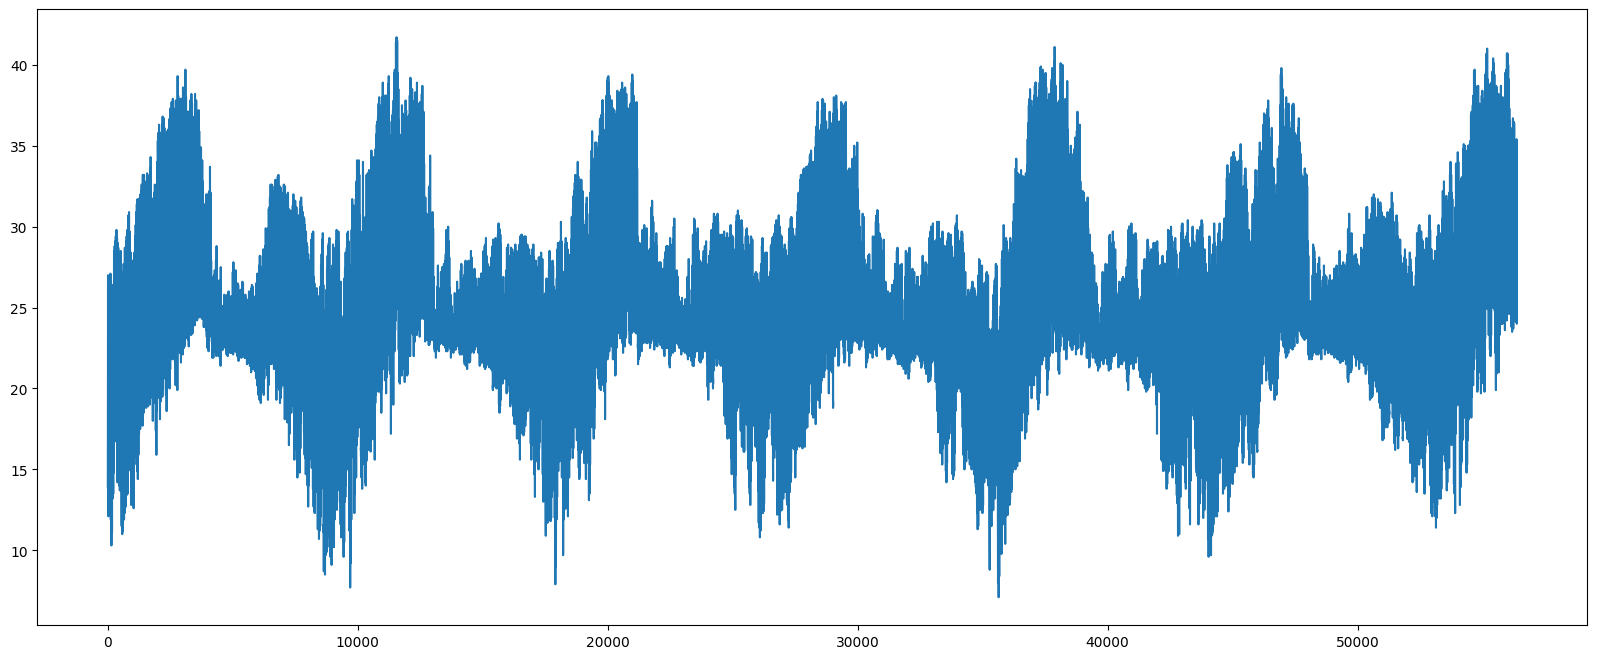

In [20]:
#Valores de Saída
plt.figure(figsize=(20,8))
plt.plot(y)
plt.show()

In [21]:
X_seq = np.transpose(X_seq, (0, 2, 1))  # (n_amostras, n_features, seq_len)


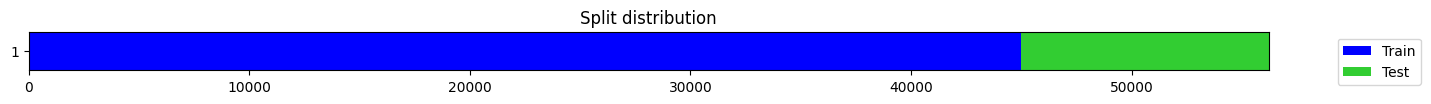

In [22]:
# Divisão dos dados em splits
splits = get_splits(y_seq, valid_size=0.2, shuffle=False, stratify=False)

# data loaders
tfms = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X_seq, y_seq, splits=splits, tfms=tfms, bs=64,batch_tfms=batch_tfms)

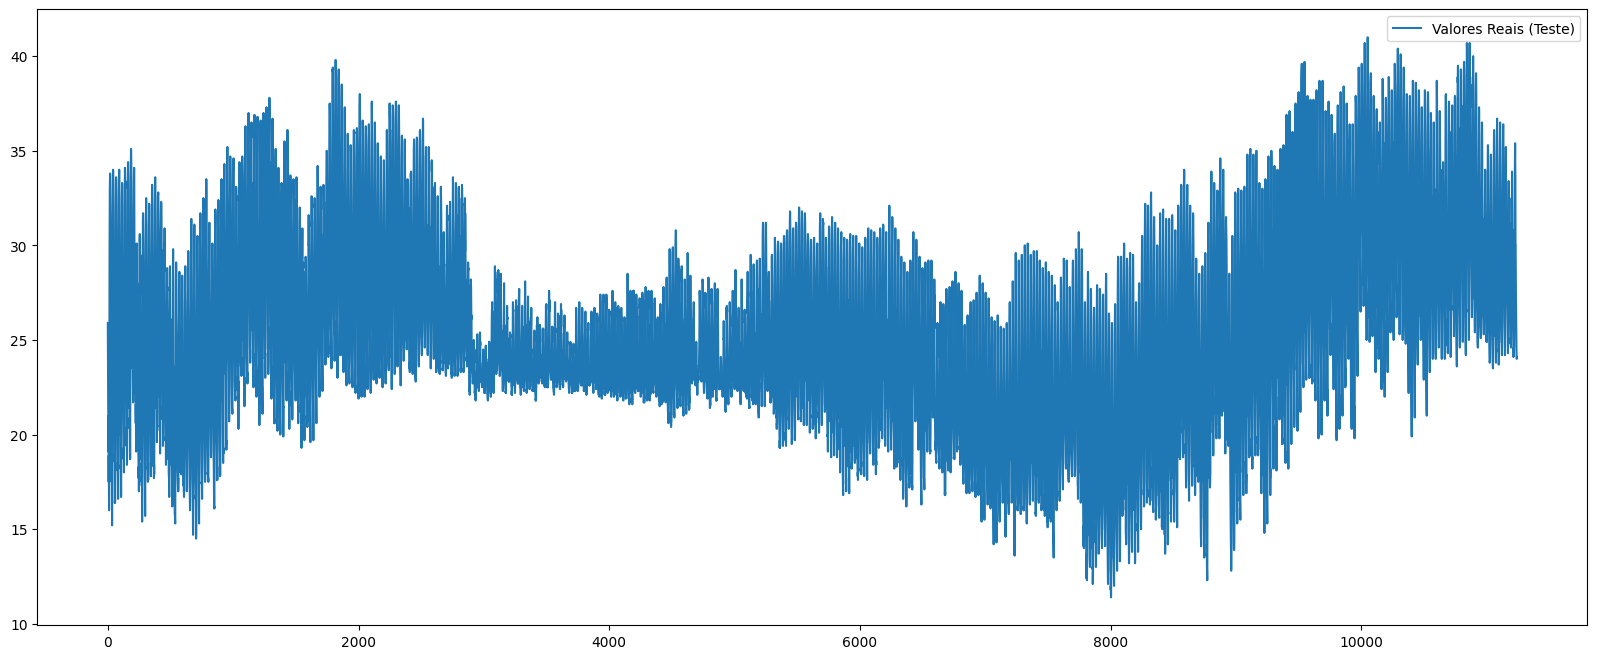

In [23]:
#Visualização dos valores de teste

plt.figure(figsize=(20,8))
plt.plot(y_seq[splits[1]], label='Valores Reais (Teste)')
plt.legend()
plt.show()

In [24]:
# Obter as datas correspondentes aos valores de y_seq

window_size = 168
horizon = 1
test_indices = splits[1]

y_seq_dates = df['time'].iloc[window_size + horizon - 1:].reset_index(drop=True)

# Selecionar as datas do conjunto de teste
test_dates = y_seq_dates.iloc[test_indices]

print("Datas do conjunto de teste:")
display(test_dates.head())
print("\nÚltimas datas do conjunto de teste:")
display(test_dates.tail())

Datas do conjunto de teste:


44967   2023-02-24 15:00:00
44968   2023-02-24 16:00:00
44969   2023-02-24 17:00:00
44970   2023-02-24 18:00:00
44971   2023-02-24 19:00:00
Name: time, dtype: datetime64[ns]


Últimas datas do conjunto de teste:


56203   2024-06-06 19:00:00
56204   2024-06-06 20:00:00
56205   2024-06-06 21:00:00
56206   2024-06-06 22:00:00
56207   2024-06-06 23:00:00
Name: time, dtype: datetime64[ns]

In [25]:
#Shape dos batches
#batch formado por 64 elementos compostos por 168 registros de 12 variáveis
xb, yb = dls.one_batch()

print("Shape X:", xb.shape)  # (bs, n_features, seq_len)
print("Shape y:", yb.shape)  # (bs,)

Shape X: torch.Size([64, 12, 168])
Shape y: torch.Size([64])


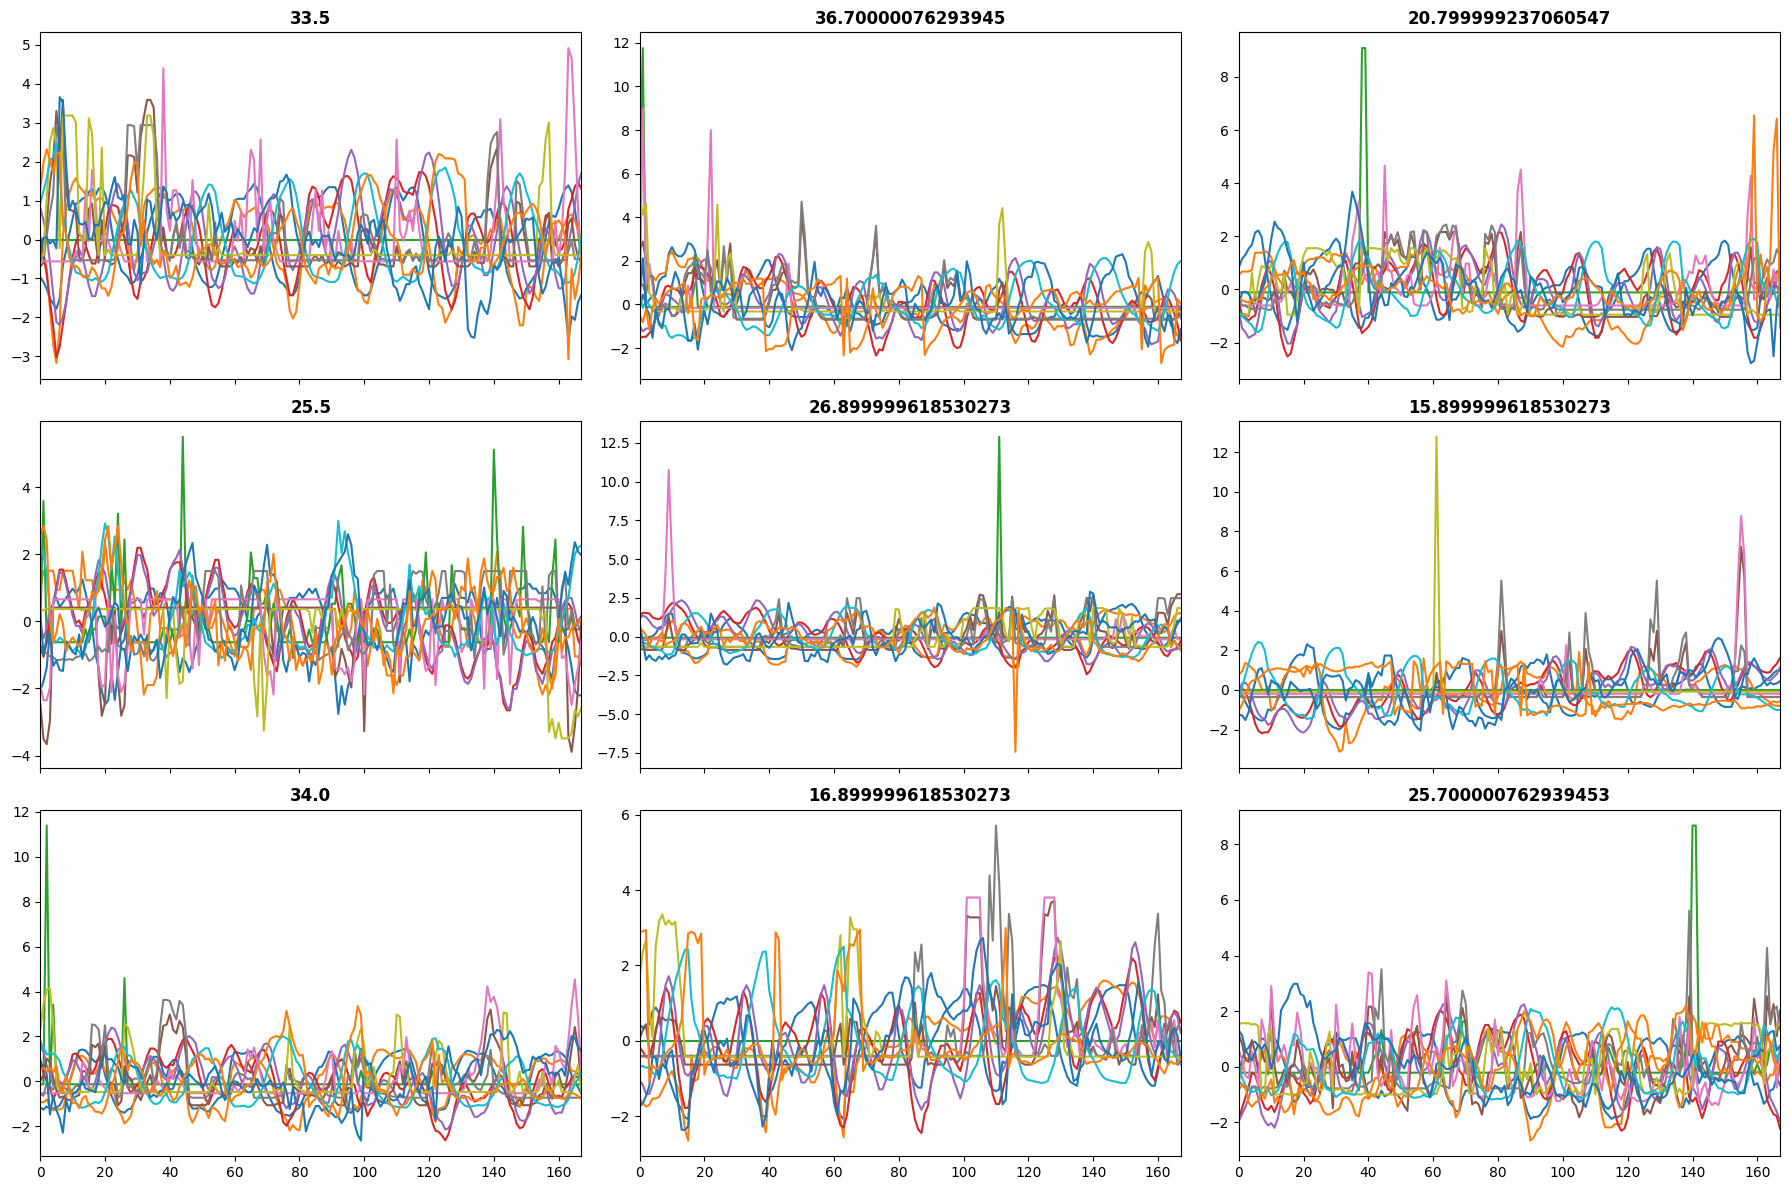

In [26]:
#Visualização dos batches
dls.show_batch()

In [27]:
# Callback: terminar o treinamento se não houver redução na função perda após 3 épocas consecutivas

early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)

In [28]:
#Salvar os parametros da época com menor valor de função de perda

save_best_cb = SaveModelCallback(monitor='valid_loss',
                                 fname='best_tstplus_model_loss_min')

all_cbs = [early_stop_cb, save_best_cb, ShowGraph()]

##Regressão (TSTPlus)

**https://timeseriesai.github.io/tsai/models.tstplus.html**

SuggestedLRs(valley=0.0008317637839354575)

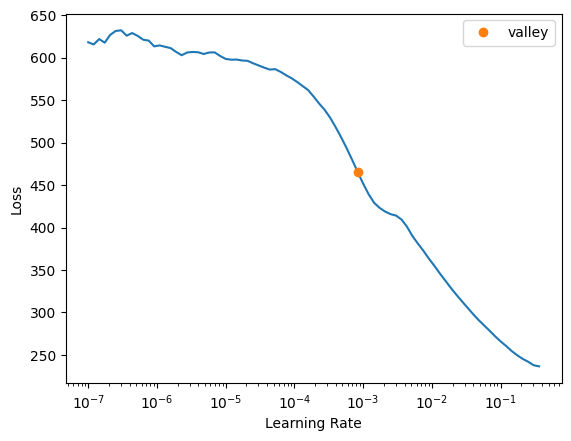

In [29]:

learn_tst = ts_learner(dls, TSTPlus, metrics=mae, cbs=ShowGraph())

# procurar LR
learn_tst.lr_find()

Better model found at epoch 0 with valid_loss value: 4.834552764892578.


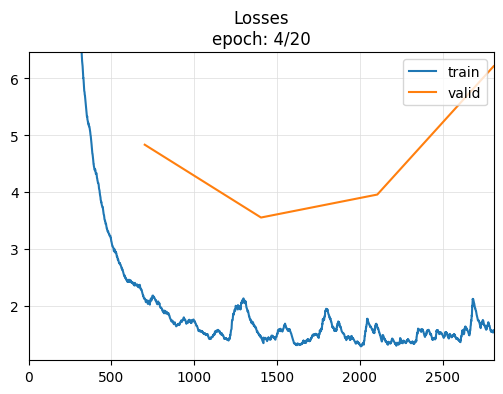

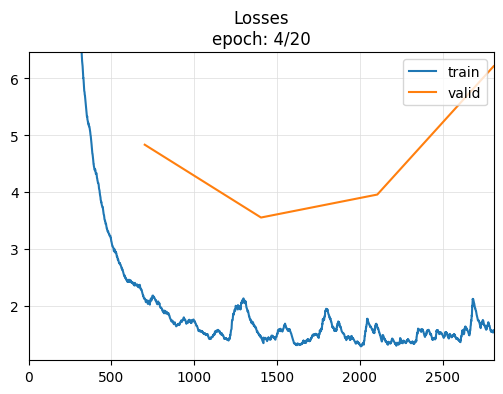

Better model found at epoch 1 with valid_loss value: 3.553175926208496.
No improvement since epoch 1: early stopping


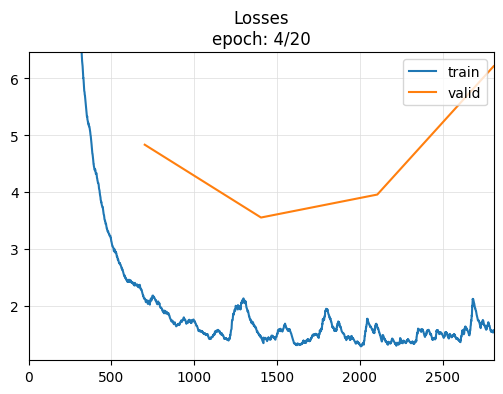

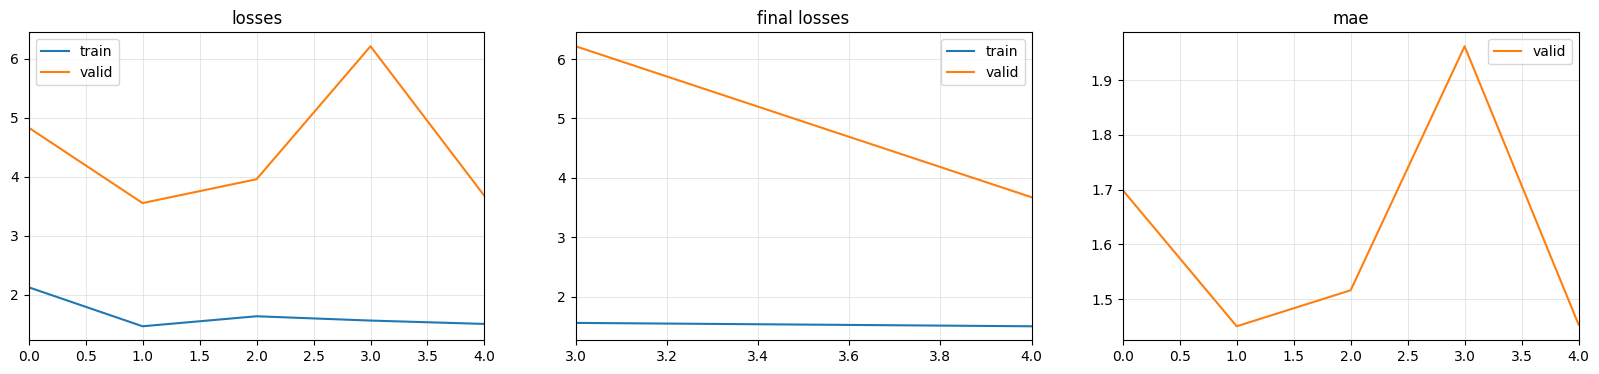

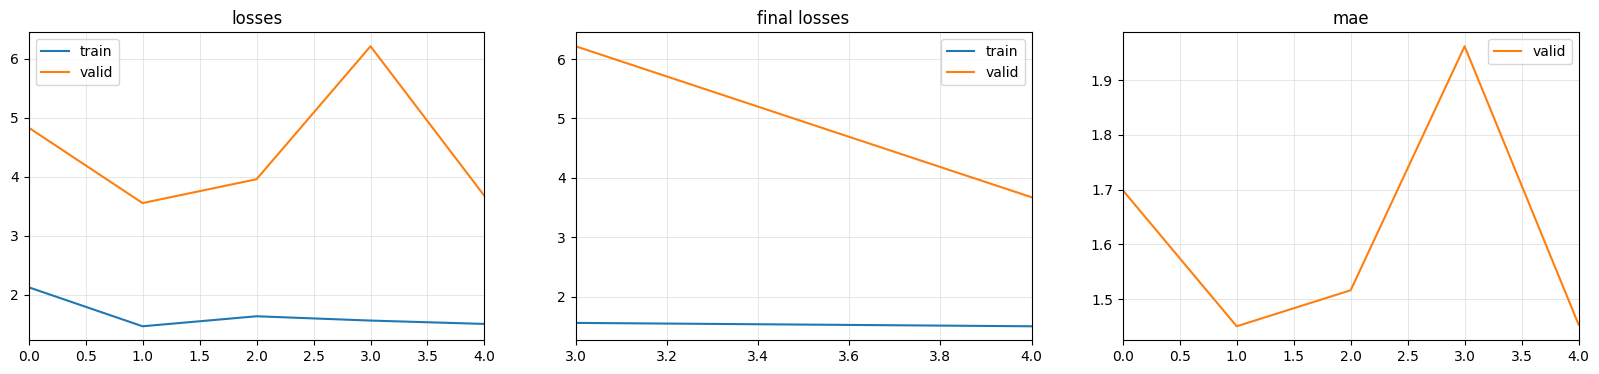

In [30]:
#Treinamento em 20 épocas
learn_tst.fit_one_cycle(20, cbs=all_cbs)


not enough values to plot a chart


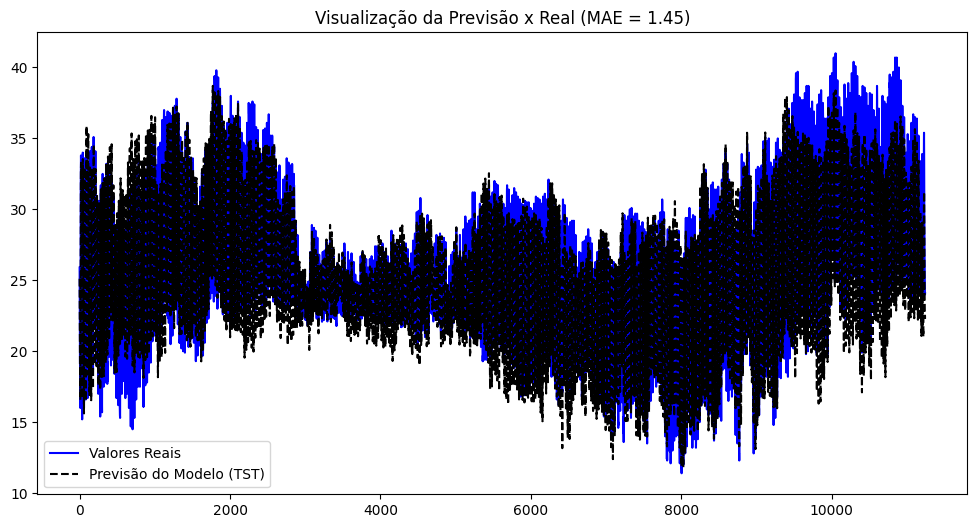

In [31]:
# Obter previsões e valores reais do modelo TST
preds_tst, target = learn_tst.get_preds()
preds_tst = preds_tst.detach().numpy().flatten()
target = target.detach().numpy().flatten()

# Calcular MAE
mae_tst = learn_tst.validate()[1]

# Criar um array de índices para o eixo x
x_data = np.arange(len(target))

# Configurar o gráfico
plt.figure(figsize=(12, 6))

# Plotar os valores reais
plt.plot(x_data, target, label='Valores Reais', color='blue')

# Plotar os valores previstos
plt.plot(x_data, preds_tst, label='Previsão do Modelo (TST)', color='black', linestyle='--')

# Adicionar legenda e título
plt.legend()
plt.title(f"Visualização da Previsão x Real (MAE = {mae_tst:.2f})")
plt.show()

## Regressão (Inception Time Plus)

**https://timeseriesai.github.io/tsai/models.inceptiontimeplus.html**

SuggestedLRs(valley=0.007585775572806597)

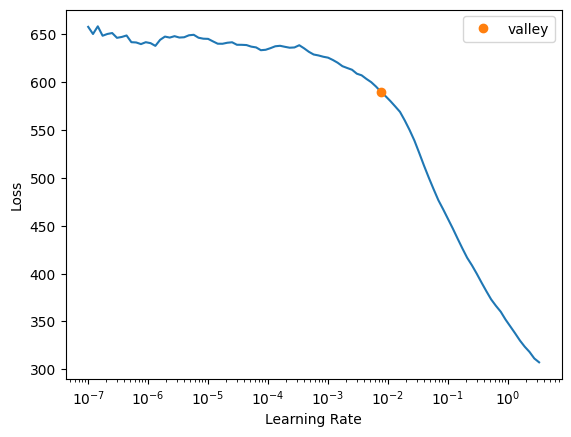

In [32]:
#Visualização dos Dados (Previsto x Real)
learn_inception = ts_learner(dls, InceptionTimePlus, metrics=mae,cbs=ShowGraph())

# procurar LR
learn_inception.lr_find()

Better model found at epoch 0 with valid_loss value: 351.1668395996094.


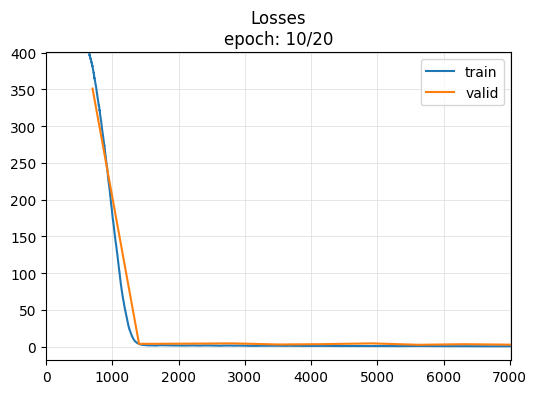

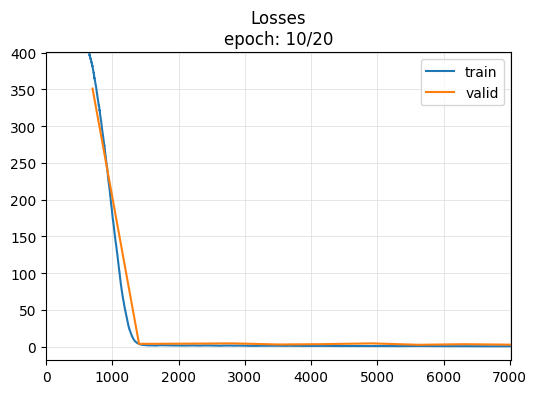

Better model found at epoch 1 with valid_loss value: 3.803999900817871.
Better model found at epoch 4 with valid_loss value: 2.9372313022613525.
Better model found at epoch 7 with valid_loss value: 2.531038999557495.
No improvement since epoch 7: early stopping


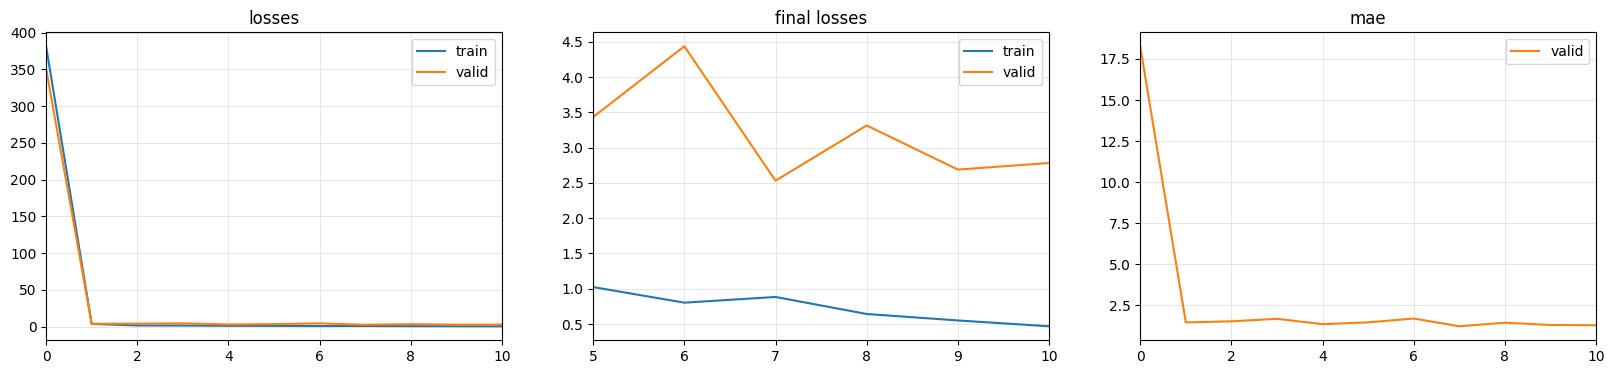

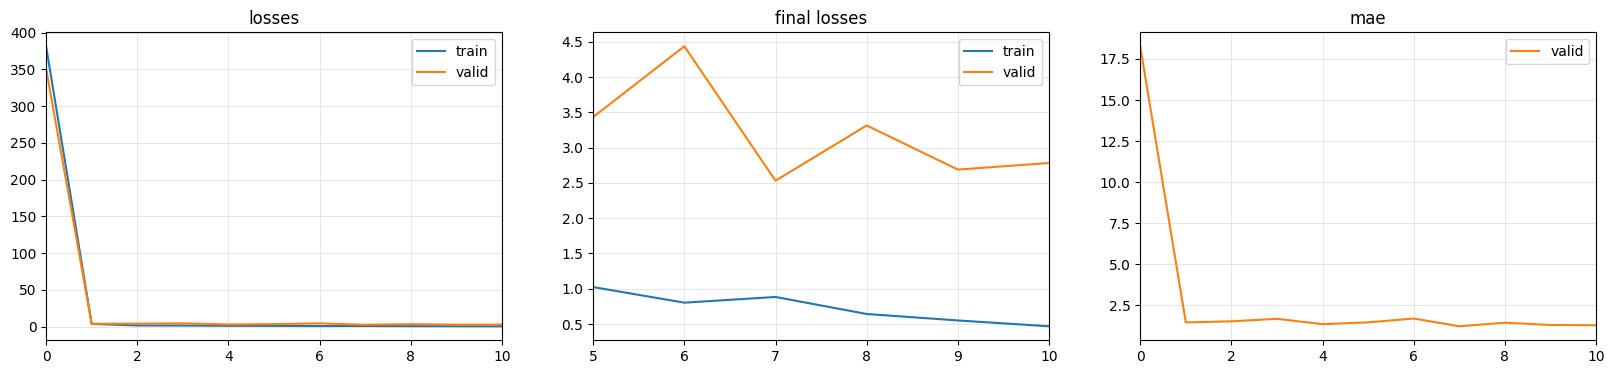

In [33]:
#Treinamento em 20 épocas
learn_inception.fit_one_cycle(20, cbs=all_cbs)


In [34]:
# preds_inception, target = learn_inception.get_preds()
# plt.figure(figsize=(20,8))
# plt.plot(y_seq[splits[1]], label="Real")
# plt.plot(preds_inception, label="Predito")
# plt.legend()
# plt.show()

not enough values to plot a chart


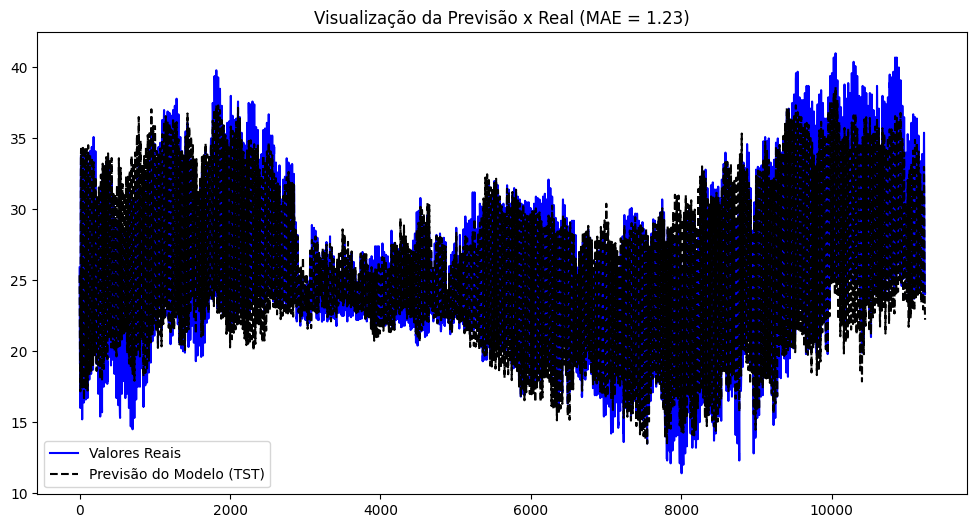

In [35]:
# Obter previsões e valores reais do modelo TST
preds_inception, target = learn_inception.get_preds()
preds_inception = preds_inception.detach().numpy().flatten()
target = target.detach().numpy().flatten()

# Calcular MAE
mae_inception = learn_inception.validate()[1]

# Criar um array de índices para o eixo x
x_data = np.arange(len(target))

# Configurar o gráfico
plt.figure(figsize=(12, 6))

# Plotar os valores reais
plt.plot(x_data, target, label='Valores Reais', color='blue')

# Plotar os valores previstos
plt.plot(x_data, preds_inception, label='Previsão do Modelo (TST)', color='black', linestyle='--')

# Adicionar legenda e título
plt.legend()
plt.title(f"Visualização da Previsão x Real (MAE = {mae_inception:.2f})")
plt.show()

##Forecasting (TST Plus)

In [36]:
#Usar valores minimos de temperatura para a previsão
ts = df['temperature'].values

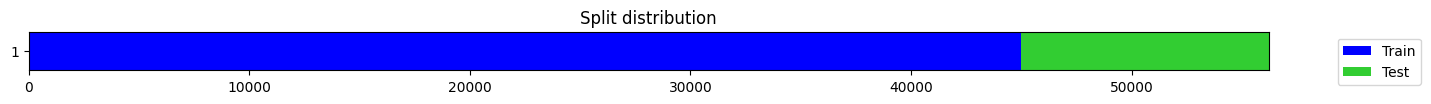

In [37]:
X, y = SlidingWindow(7*24, horizon=1)(ts) #Janela deslizante com um tamanho de 60. Isso significa que cada amostra de entrada (X) será uma sequência de 60 valores consecutivos da série temporal. Horizon =1 prever apenas 1 passo à frente
splits = TimeSplitter(int(0.2*len(X)))(y)#Cria uma divisão onde as últimas 1800 observações de y são usadas para o conjunto de Teste, e o restante é usado para o conjunto de treinamento.

In [38]:
tfms = [None, TSForecasting()]
batch_tfms = TSStandardize()

SuggestedLRs(valley=0.0012022644514217973)

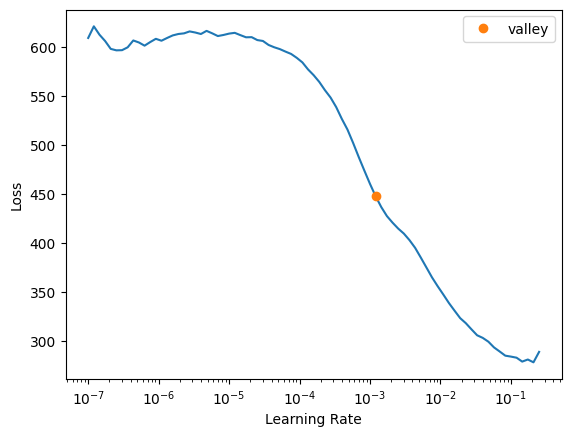

In [39]:
fcst_tst = TSForecaster(X, y, splits=splits, path='models', tfms=tfms, batch_tfms=batch_tfms, bs=64, arch="TSTPlus", metrics=mae, cbs=ShowGraph())
fcst_tst.lr_find()



Better model found at epoch 0 with valid_loss value: 1.3147729635238647.


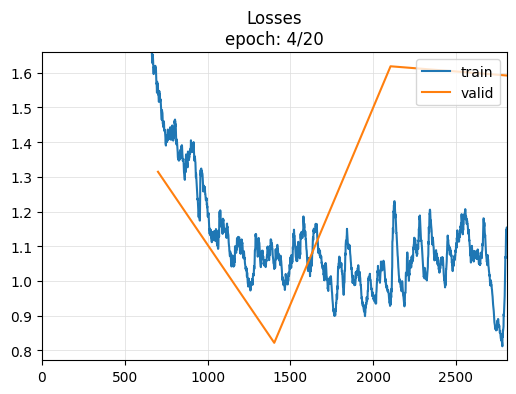

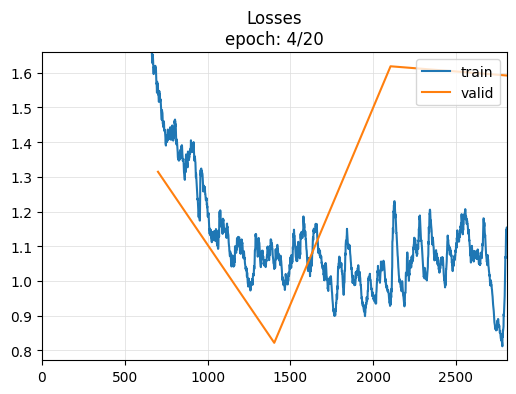

Better model found at epoch 1 with valid_loss value: 0.821952760219574.
No improvement since epoch 1: early stopping


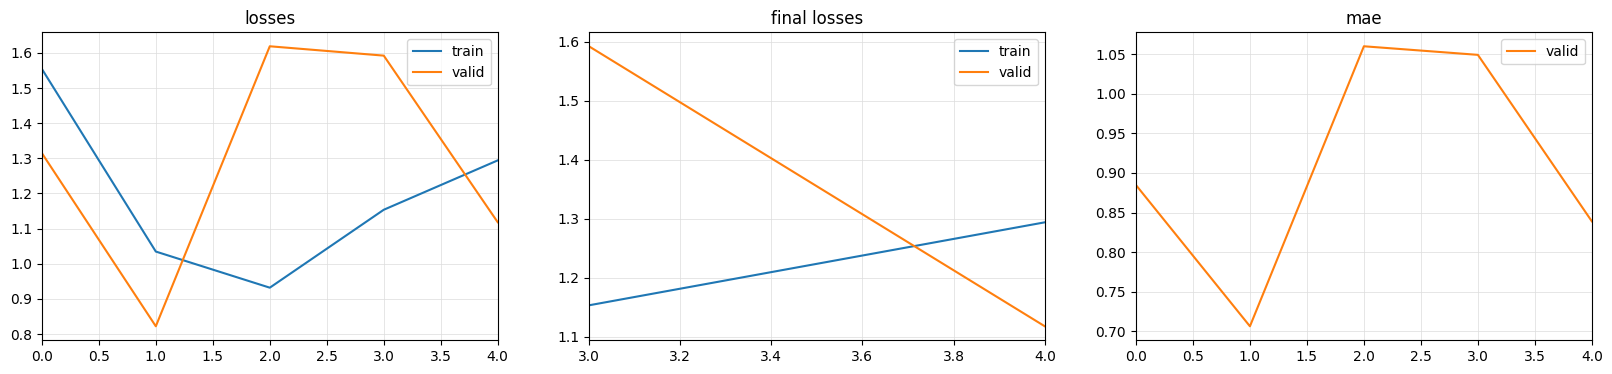

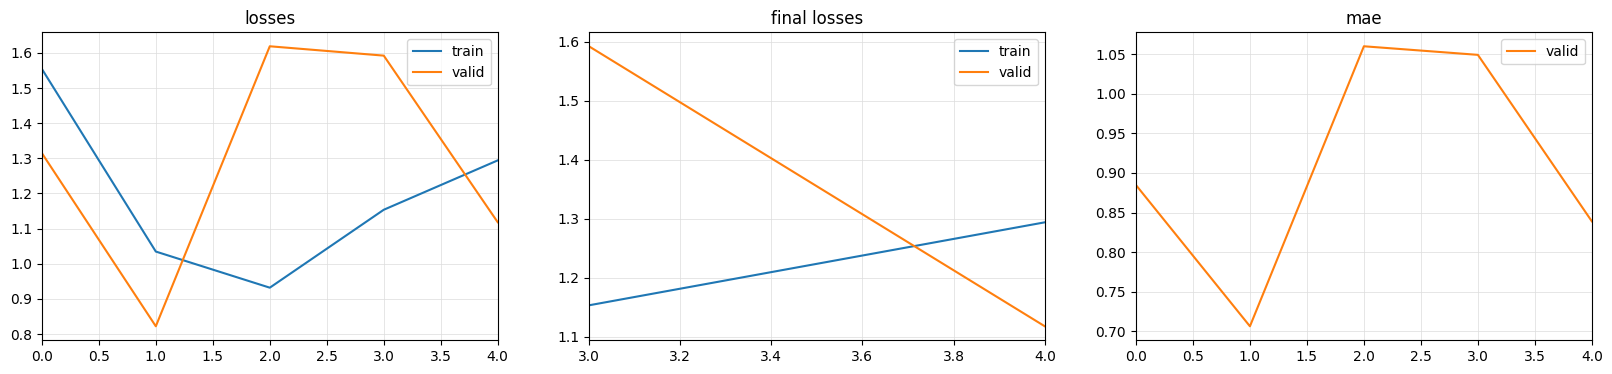

In [40]:
fcst_tst.fit_one_cycle(20, cbs=all_cbs)

In [41]:
y_preds_fcst_tst, y_true = fcst_tst.get_preds()

not enough values to plot a chart


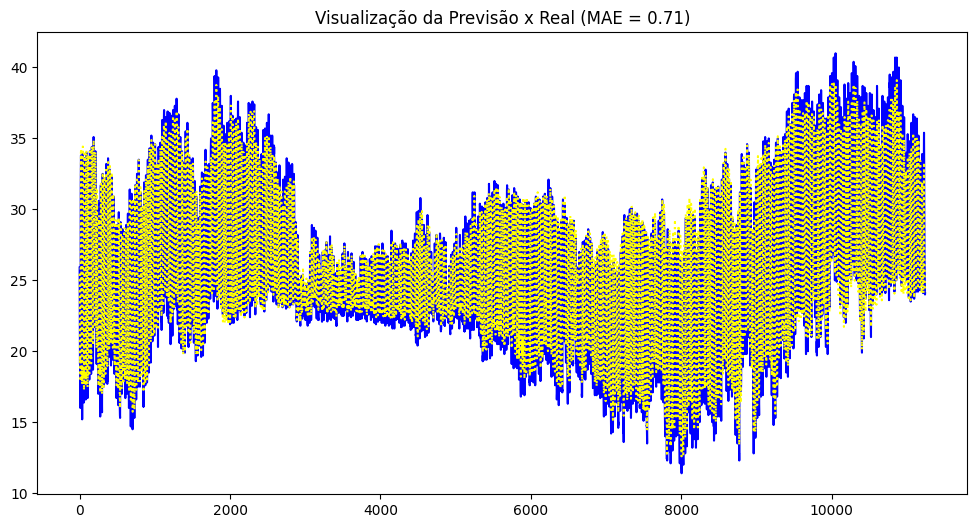

In [42]:
# Visualização da Previsão x Real



x_data = np.arange(len(y_true))

# Configurar o gráfico
plt.figure(figsize=(12, 6))

# Plotar os valores reais
plt.plot(x_data, y_true, label='Valores Reais', color='blue')

# Plotar os valores previstos
plt.plot(x_data, y_preds_fcst_tst, label='Previsão do Modelo', color='yellow', linestyle=':')

plt.title(f"Visualização da Previsão x Real (MAE = {fcst_tst.validate()[1]:.2f})")
plt.show()


##Forecasting (Inception)

SuggestedLRs(valley=0.00363078061491251)

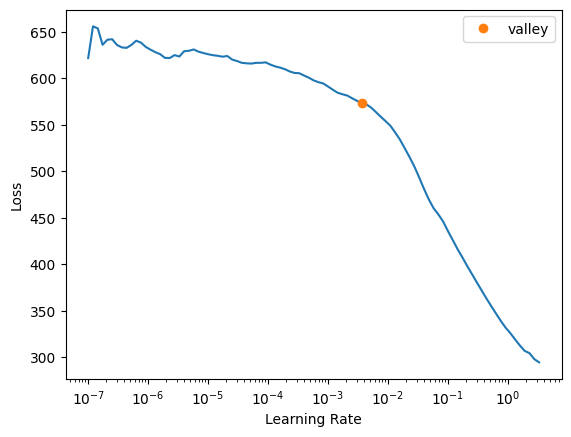

In [43]:
fcst_inception = TSForecaster(X, y, splits=splits, path='models', tfms=tfms, batch_tfms=batch_tfms, bs=64, arch="InceptionTimePlus", metrics=mae)
fcst_inception.lr_find()



Better model found at epoch 0 with valid_loss value: 281.128173828125.


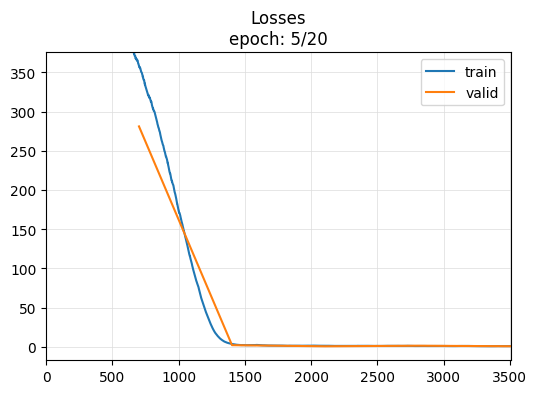

Better model found at epoch 1 with valid_loss value: 2.032547950744629.
Better model found at epoch 2 with valid_loss value: 0.6242790818214417.
No improvement since epoch 2: early stopping


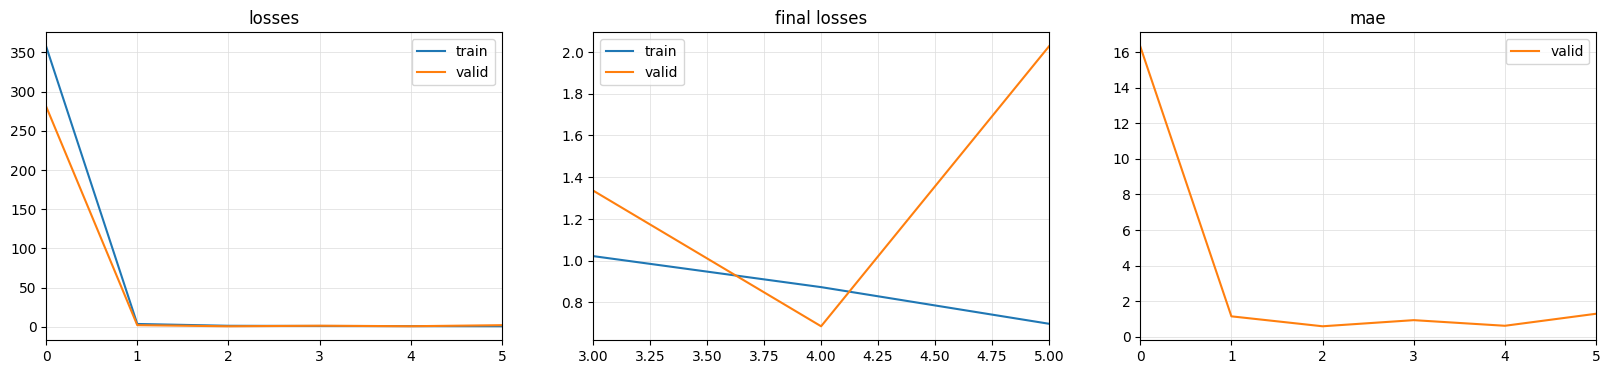

In [44]:
fcst_inception.fit_one_cycle(20, cbs=all_cbs)


In [45]:
y_preds_fcst_inception, y_true = fcst_inception.get_preds()

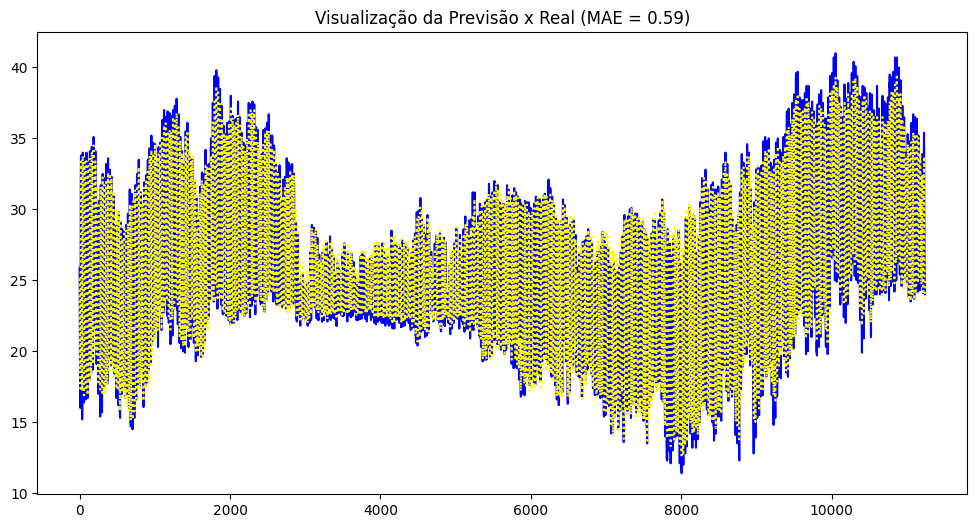

In [46]:
# Visualização da Previsão x Real

x_data = np.arange(len(y_true))

# Configurar o gráfico
plt.figure(figsize=(12, 6))

# Plotar os valores reais
plt.plot(x_data, y_true, label='Valores Reais', color='blue')

# Plotar os valores previstos
plt.plot(x_data, y_preds_fcst_inception, label='Previsão do Modelo', color='yellow', linestyle=':')
plt.title(f"Visualização da Previsão x Real (MAE = {fcst_inception.validate()[1]:.2f})")
plt.show()


#Comparativo dos Modelos


In [47]:
#Alocação das perdas em novas variáveis

tst_loss, tst_mae=learn_tst.validate()
inception_loss, inception_mae=learn_inception.validate()
fcst_tst_loss, fcst_tst_mae=fcst_tst.validate()
fcst_inception_loss, fcst_inception_mae=fcst_inception.validate()


not enough values to plot a chart


not enough values to plot a chart


not enough values to plot a chart


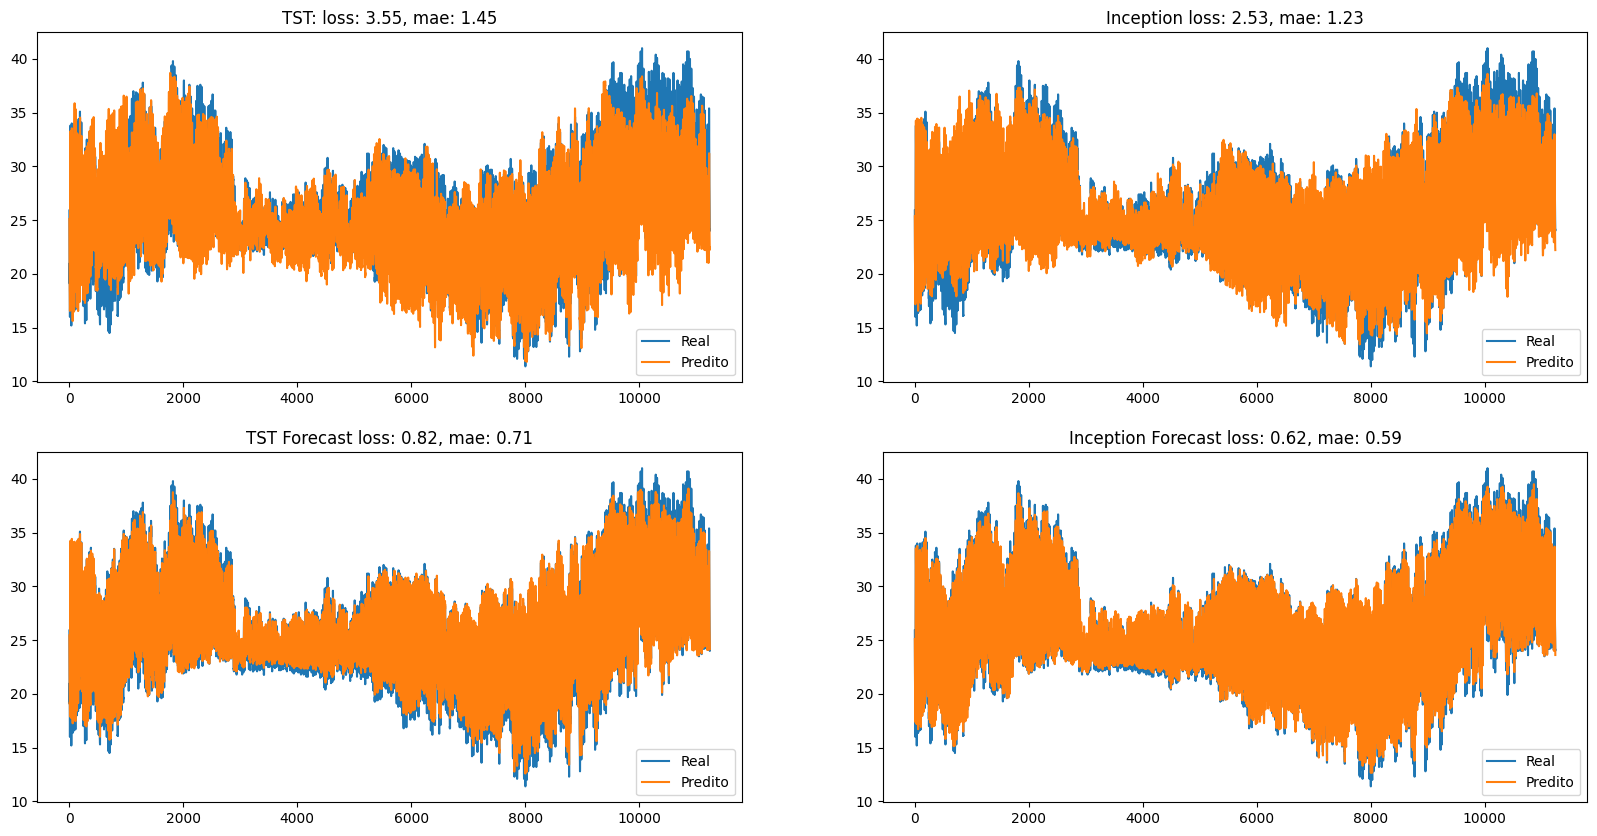

In [48]:
#Gráfico comparativo dos modelos

fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].plot(y[splits[1]])
ax[0,0].plot(preds_tst)
ax[0,0].set_title(f'TST: loss: {tst_loss:.2f}, mae: {tst_mae:.2f}')
ax[0,0].legend(['Real', 'Predito'])


ax[0,1].plot(y[splits[1]], label='Real')
ax[0,1].plot(preds_inception)
ax[0,1].set_title(f'Inception loss: {inception_loss:.2f}, mae: {inception_mae:.2f}')
ax[0,1].legend(['Real', 'Predito'])


ax[1,0].plot(y[splits[1]], label='Real')
ax[1,0].plot(y_preds_fcst_tst)
ax[1,0].set_title(f'TST Forecast loss: {fcst_tst_loss:.2f}, mae: {fcst_tst_mae:.2f}')
ax[1,0].legend(['Real', 'Predito'])


ax[1,1].plot(y[splits[1]], label='Real')
ax[1,1].plot(y_preds_fcst_inception)
ax[1,1].set_title(f'Inception Forecast loss: {fcst_inception_loss:.2f}, mae: {fcst_inception_mae:.2f}')
ax[1,1].legend(['Real', 'Predito'])



#Prophet

In [49]:
df

time  temperature  relative_humidity  dew_point  \
333120 2018-01-01 00:00:00         13.9                 81       10.7   
333121 2018-01-01 01:00:00         14.6                 75       10.2   
333122 2018-01-01 02:00:00         15.6                 69       10.0   
333123 2018-01-01 03:00:00         16.8                 69       11.0   
333124 2018-01-01 04:00:00         20.3                 56       11.2   
...                    ...          ...                ...        ...   
389491 2024-06-06 19:00:00         24.8                 90       23.0   
389492 2024-06-06 20:00:00         24.3                 92       22.9   
389493 2024-06-06 21:00:00         24.1                 91       22.5   
389494 2024-06-06 22:00:00         24.0                 89       22.1   
389495 2024-06-06 23:00:00         24.1                 88       22.0   

        rain (mm)  pressure_msl (hPa)  surface_pressure (hPa)  \
333120        0.0              1011.0                   943.7   
333121        0.0              1011.3                   944.1   
333122        0.0              1012.0                   945.0   
333123        0.0              1013.2                   946.4   
333124        0.0              1013.8                   947.7   
...           ...                 ...                     ...   
389491        0.0              1010.1                   945.2   
389492        0.0              1009.4                   944.4   
389493        0.0              1008.7                   943.7   
389494        0.0              1008.2                   943.2   
389495        0.0              1008.2                   943.3   

        cloud_cover (%)  cloud_cover_low (%)  cloud_cover_mid (%)  \
333120                0                    0                    0   
333121                0                    0                    0   
333122                0                    0                    0   
333123                0                    0                    0   
333124                0                    0                    0   
...                 ...                  ...                  ...   
389491               39                    2                   12   
389492               33                    3                    1   
389493               34                    4                    1   
389494               37                    8                    0   
389495               58                   31                    0   

        cloud_cover_high (%)  vapour_pressure_deficit (kPa)  \
333120                     0                           0.30   
333121                     0                           0.42   
333122                     0                           0.55   
333123                     0                           0.60   
333124                     0                           1.06   
...                      ...                            ...   
389491                   100                           0.32   
389492                   100                           0.25   
389493                   100                           0.27   
389494                   100                           0.32   
389495                   100                           0.35   

        wind_speed_10m (km/h)  wind_direction  
333120                    3.2             297  
333121                    3.6             270  
333122                    1.5             315  
333123                    1.1             288  
333124                    1.1             198  
...                       ...             ...  
389491                   10.6             252  
389492                   11.9             265  
389493                   13.1             261  
389494                   13.7             267  
389495                   14.5             264  

[56376 rows x 14 columns]

In [50]:
df_prophet=df[['time','temperature']]

In [51]:
df_prophet.columns=['ds','y']

In [52]:
df_prophet

ds     y
333120 2018-01-01 00:00:00  13.9
333121 2018-01-01 01:00:00  14.6
333122 2018-01-01 02:00:00  15.6
333123 2018-01-01 03:00:00  16.8
333124 2018-01-01 04:00:00  20.3
...                    ...   ...
389491 2024-06-06 19:00:00  24.8
389492 2024-06-06 20:00:00  24.3
389493 2024-06-06 21:00:00  24.1
389494 2024-06-06 22:00:00  24.0
389495 2024-06-06 23:00:00  24.1

[56376 rows x 2 columns]

In [53]:
#Inicialização e fit do modelo

model = Prophet()

model.fit(df_prophet)

In [54]:
#Criar um novo data frame com horários futuros (720 horas - 30 dias)
future = model.make_future_dataframe(freq='H',periods=720)


In [55]:
#Gerando a previsão
forecast = model.predict(future)

In [56]:
#Visualização das primeiras linhas do df de previsão
forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2018-01-01 00:00:00  24.640814   12.696691   18.492555    24.640814   
1 2018-01-01 01:00:00  24.640752   12.850543   18.805634    24.640752   
2 2018-01-01 02:00:00  24.640690   14.187463   19.839578    24.640690   
3 2018-01-01 03:00:00  24.640628   16.203686   21.832112    24.640628   
4 2018-01-01 04:00:00  24.640566   18.269391   24.175572    24.640566   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    24.640814       -8.974832             -8.974832             -8.974832   
1    24.640752       -8.717247             -8.717247             -8.717247   
2    24.640690       -7.576642             -7.576642             -7.576642   
3    24.640628       -5.595408             -5.595408             -5.595408   
4    24.640566       -3.267819             -3.267819             -3.267819   

      daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0 -4.756244  ...  0.018661      0.018661      0.018661 -4.237249   
1 -4.499361  ...  0.018942      0.018942      0.018942 -4.236827   
2 -3.359750  ...  0.019513      0.019513      0.019513 -4.236405   
3 -1.379800  ...  0.020374      0.020374      0.020374 -4.235982   
4  0.946219  ...  0.021521      0.021521      0.021521 -4.235559   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -4.237249     -4.237249                   0.0   
1     -4.236827     -4.236827                   0.0   
2     -4.236405     -4.236405                   0.0   
3     -4.235982     -4.235982                   0.0   
4     -4.235559     -4.235559                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0  15.665982  
1                         0.0                         0.0  15.923506  
2                         0.0                         0.0  17.064049  
3                         0.0                         0.0  19.045221  
4                         0.0                         0.0  21.372747  

[5 rows x 22 columns]

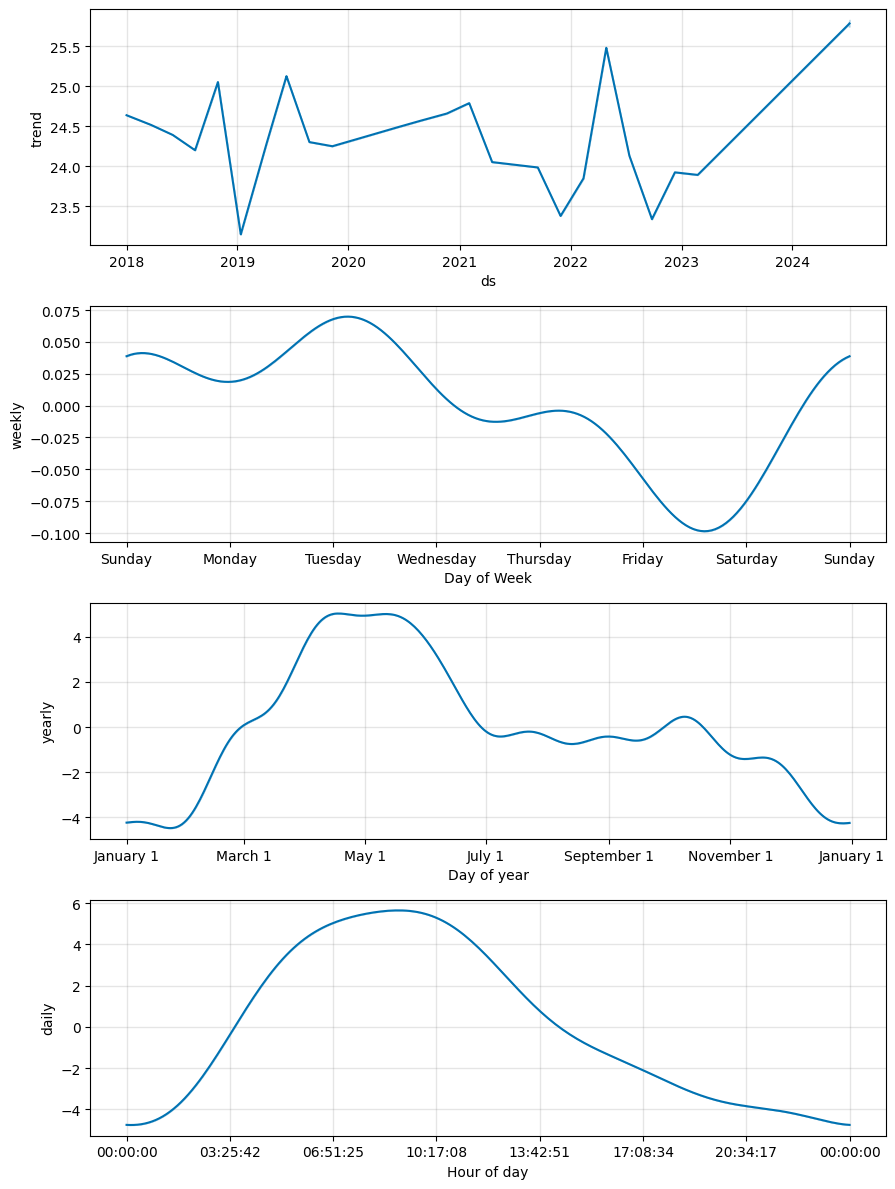

In [57]:
#Componentes da série temporal (Tendência e Sazonalidade)

model.plot_components(forecast)
plt.show()

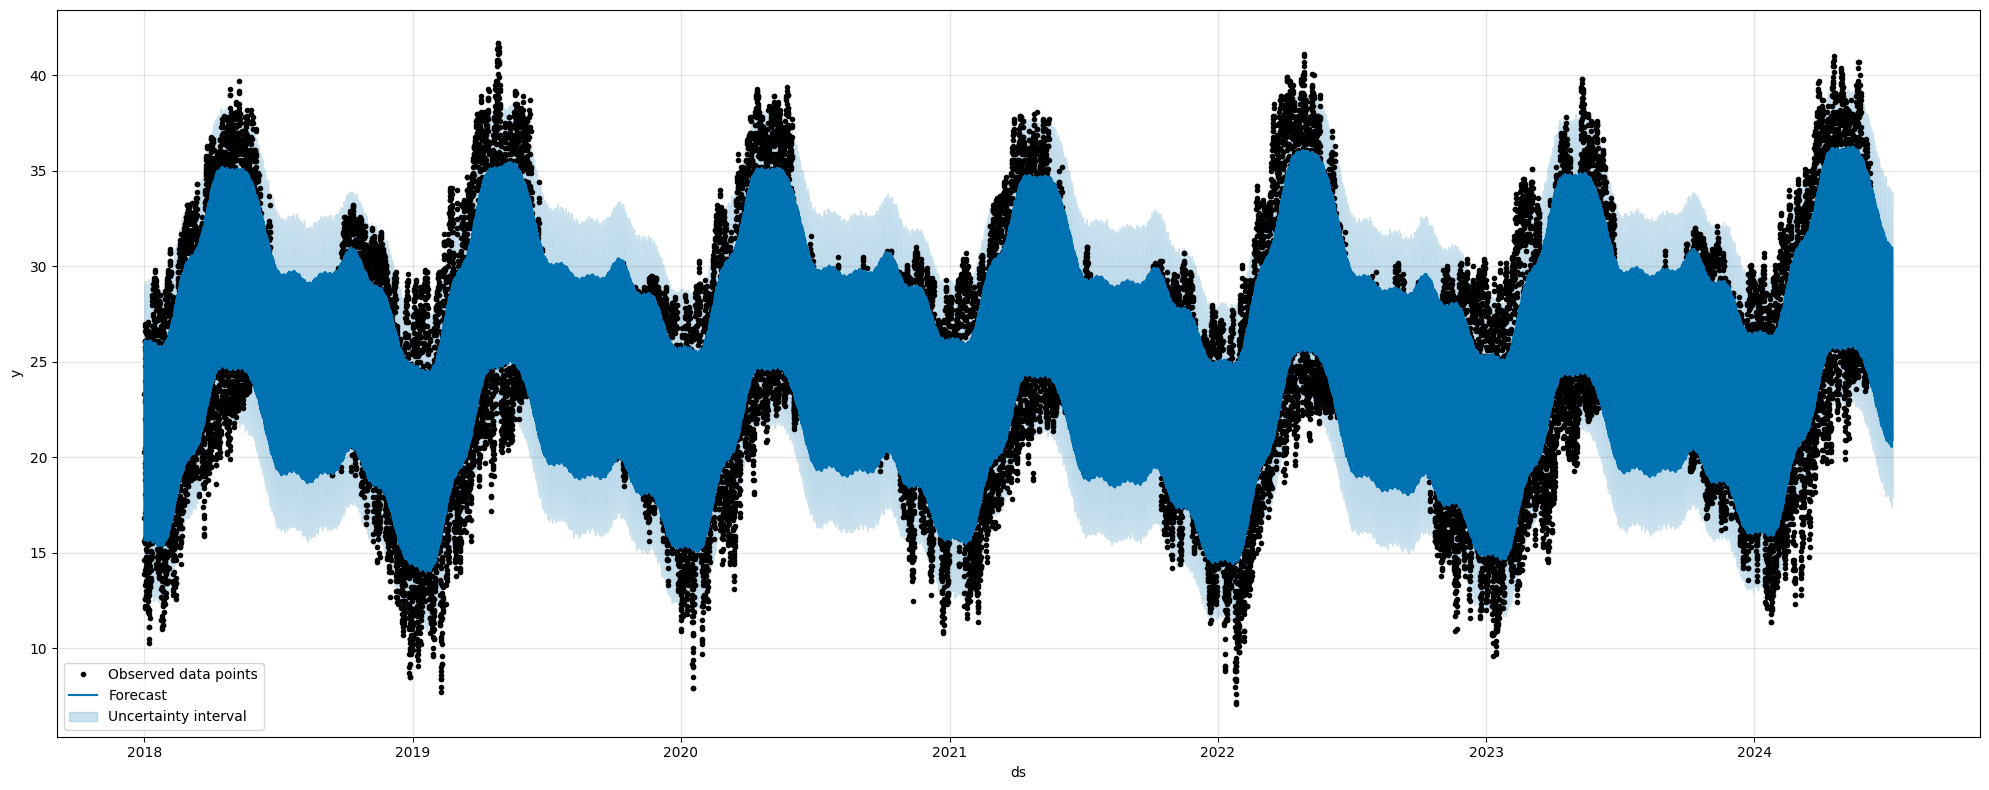

In [58]:
#Visualização das previsões realizadas com intervalo de confiança

model.plot(forecast,include_legend=True, figsize=(20,8))

plt.show()

In [59]:
# Divisão de dados em treino e teste para comparar com modelos treinados no TSAI

treino = df_prophet.iloc[:11241]  # Exemplo: usar todos menos o último ano para treino
teste = df_prophet.iloc[-11241:]   # Exemplo: usar o último ano para teste

In [60]:
# Criar um DataFrame futuro para o período de teste
future = model.make_future_dataframe(periods=len(teste), freq='H')

# Fazer as previsões
previsao = model.predict(future)

# Filtrar as previsões para o período de teste
previsao_teste = previsao.iloc[-len(teste):]

In [61]:
# Obter os valores reais do conjunto de teste
valores_reais = teste['y']

# Obter as previsões correspondentes
previsoes_modelo = previsao_teste['yhat']

# Calcular o MAE
mae_prophet = mean_absolute_error(valores_reais, previsoes_modelo)

print(f"O MAE do modelo é: {mae_prophet}")

O MAE do modelo é: 7.179325363521771


In [62]:
df_pred = pd.DataFrame({'data': teste['ds'].values,
                        'prev': previsoes_modelo.values,
                        'upper': previsao_teste['yhat_upper'].values,
                        'lower': previsao_teste['yhat_lower'].values,
                        'real': valores_reais.values})

In [63]:
df_pred

data       prev      upper      lower  real
0     2023-02-24 15:00:00  23.871571  26.868800  20.834258  25.9
1     2023-02-24 16:00:00  24.118102  26.915094  21.254288  24.3
2     2023-02-24 17:00:00  25.247429  28.193596  22.547048  23.1
3     2023-02-24 18:00:00  27.217208  29.939318  24.488183  21.7
4     2023-02-24 19:00:00  29.533215  32.272245  26.688299  21.0
...                   ...        ...        ...        ...   ...
11236 2024-06-06 19:00:00  27.831149  38.846067  16.692492  24.8
11237 2024-06-06 20:00:00  29.869922  40.082134  18.610381  24.3
11238 2024-06-06 21:00:00  31.247170  42.196444  19.361726  24.1
11239 2024-06-06 22:00:00  32.002643  42.398592  20.426207  24.0
11240 2024-06-06 23:00:00  32.387913  42.940438  20.760997  24.1

[11241 rows x 5 columns]

In [64]:
df_pred.set_index('data', inplace=True)


Text(0.5, 1.0, 'MAE: 7.179325363521771')

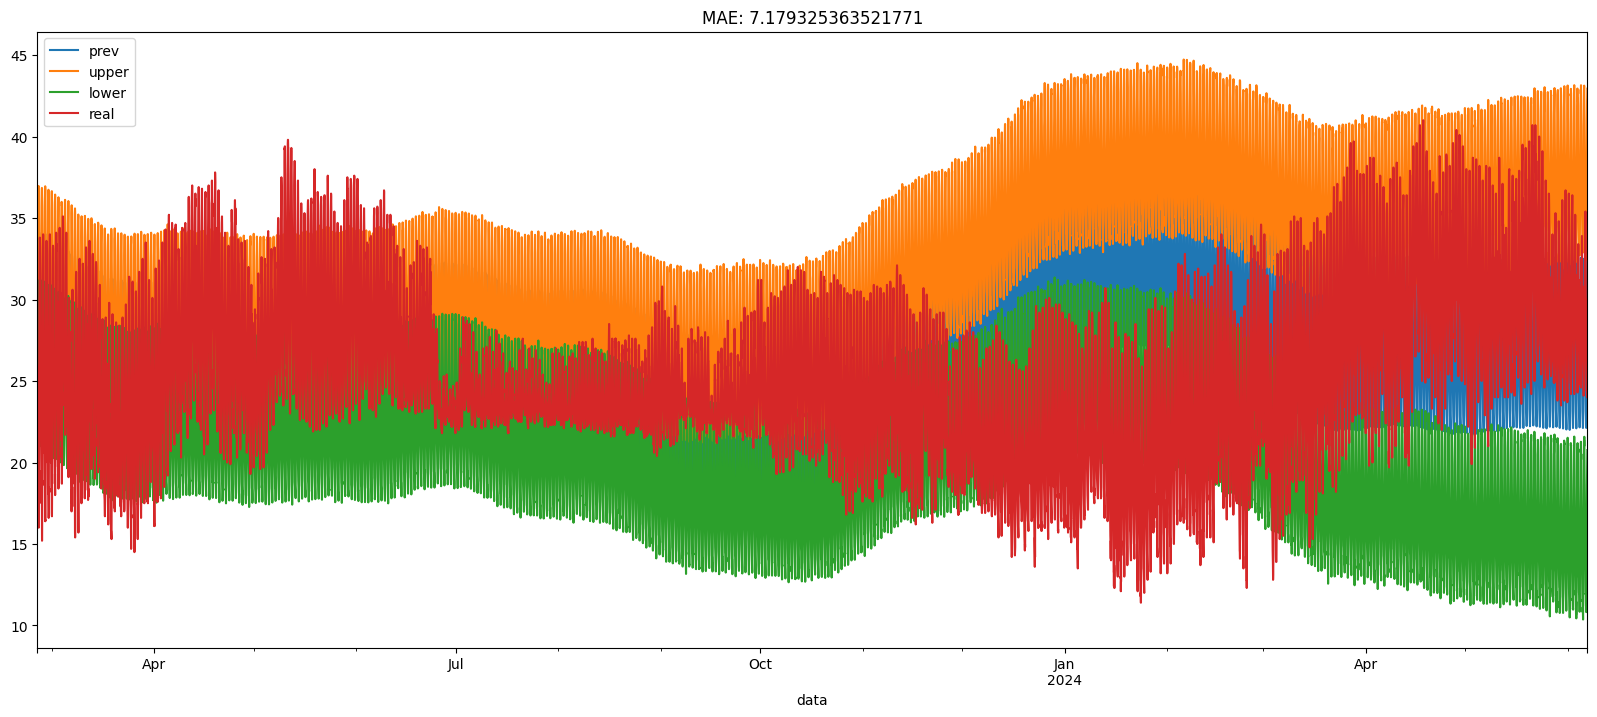

In [65]:
#Visualização dos Dados

df_pred.plot(figsize=(20,8))
plt.title(f'MAE: {mae_prophet}')

#Conclusão

O projeto teve como objetivo a aplicação de técnicas avançadas de **Machine Learning em Séries Temporais** para a previsão da temperatura horária, utilizando um conjunto de dados meteorológicos multivariados (incluindo umidade, precipitação, pressão e velocidade do vento).

Os dados originais listam medições desde 1980, porém para fins de análise, os dados foram filtrados para datas a partir de 2018.

Na etapa de EDA dos dados foi observado que:
- Não existiam dados nulos
- Não existiam dados duplicado
- As features retiradas foram "is_day", "precipitation" e "snowfall"


Os aprendizados exploraram duas abordagens distintas, visando uma comparação  de desempenho:

1.  **Deep Learning (TSAI)**: Utilizando arquiteturas de ponta para Séries Temporais (TST Plus, InceptionTime Plus). Foram realizados aprendizados por Regressão e por Forecasting usando Deep Learning.
2.  **Forecasting Clássico/Estatístico (Prophet)**: Um modelo otimizado para decomposição e previsão de dados sazonais.

A métrica **MAE (Erro Absoluto Médio)** foi a escolhida para avaliar e comparar a acurácia de cada modelo.

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

O Early Stopping foi a técnica de regularização utilizada prevenir o Overfitting, interrompendo o treinamento se a perda no conjunto de validação não melhorar (queda de pelo menos 0.01) por 3 ciclos de treinamento. Além disso, foi utilizada a estratégia de salvar os parâmetros do modelo que apresentaram os menores valores de perda durante as épocas de treinamento

 1. Comparação e Desempenho dos Modelos

Após o treinamento e validação, os modelos apresentaram os seguintes resultados na métrica MAE:

| Modelo | MAE (Mean Absolute Error) |
| :--- | :--- |
| TST Plus (Regressão) | 1.45 |
| Inception Time Plus (Regress]ao)| 1.23 |
| TST Plus (Forecasting) | 0.71 |
| **Inception Time Plus (Forecasting)**| **0.59** |
| Prophet | 7.18 |


<br>

A análise dos resultados demonstra que o aprendizado por Forecasting se mostrou mais eficiente do que a Regressão Multivariada.
O modelo Inception Time Plus para Forecasting obteve o desempenho superior, com um MAE de 0.59 graus Celsius. Com base na amplitudo dos dados de temperatura observados (min: 7.1°C e máx:41.7°C), esse MAE se mostra como um bom resultado.

O **Prophet**, apesar de ser muito bom para dados com forte sazonalidade e tendências, teve seu desempenho ofuscado pelos modelos Deep Learning, o que pode ser atribuído à **complexidade da periodicidade horária e alta volatilidade dos dados**.


- Trabalhos Futuros

Para aprimorar o modelo, pode-se seguir os seguintes passos:

1.  **Otimização de Hiperparâmetros:** Realizar uma busca exaustiva (e.g., *Grid Search* ou *Bayesian Optimization*) nos hiperparâmetros do modelo vencedor, como tamanho da janela de entrada, *learning rate* e número de camadas, para potencialmente reduzir o MAE ainda mais.
2.  **Aumento do Horizonte:** Explorar previsões não apenas para o próximo passo (horizonte 1), mas também para 24, 48 ou 168 horas (7 dias) à frente, adaptando a função create_sliding_window.
3.  **Análise de Outliers e Eventos Extremos:** Investigar o desempenho dos modelos durante eventos climáticos atípicos para garantir robustez em cenários extremos.